In [4]:
import numpy as np
from pathlib import Path
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd

from hydromt.data_catalog import DataCatalog
from hydromt_sfincs import SfincsModel
from hydromt_wflow import WflowModel
from hydromt_fiat.fiat import FiatModel
from hydromt_sfincs.utils import downscale_floodmap

from flood_adapt.api import static
from flood_adapt.api.scenarios import get_scenario
from DT_flood.utils.plot_utils import plot_wflow_model, plot_fiat_model, plot_sfincs_model

In [5]:
# Path and name of FloodAdapt database
db_path = Path("/home/wotromp/InterTwin/FloodAdapt_database")
db_name = "Humber"
# Read database
db = static.read_database(database_path=db_path, site_name=db_name)

# Name of the scenario to visualize
scenario_name = "Empty_Event_current_no_measures"
# Read scenario
scenario = get_scenario(name=scenario_name, database=db)
# Get output path
out_path = scenario.results_path

# Set some useful paths
floodmap_fn = out_path/"Flooding"/f"FloodMap_{scenario.attrs.name}.tif"
sf_path = out_path/"Flooding"/"simulations"/"overland"
wf_path = out_path/"Flooding"/"simulations"/"wflow_event"
fiat_path = out_path/"Impacts"/"fiat_model"

# Init data catalog
data_catalogues = [Path("/home/wotromp/InterTwin/Data/gtsm_catalogue.yml"), Path("/home/wotromp/DestinE_workflows/deltares_data_wsl.yml")]
dc = DataCatalog(data_libs=data_catalogues)

region = gpd.read_file(db_path/db_name/"HumberDelta_large.geojson")

proj = ccrs.PlateCarree()

INFO:flood_adapt.integrator.sfincs_adapter:Initializing sfincs model from hydromt_sfincs (v1.0.3).
INFO:flood_adapt.integrator.sfincs_adapter:Model read
INFO:hydromt.data_catalog:Parsing data catalog from /home/wotromp/InterTwin/Data/gtsm_catalogue.yml
INFO:hydromt.data_catalog:Parsing data catalog from /home/wotromp/DestinE_workflows/deltares_data_wsl.yml


In [9]:
sf = SfincsModel(
    root=sf_path,
    mode='r',
    data_libs=data_catalogues,
)
sf.read()

wf = WflowModel(
    root=wf_path,
    mode='r',
    data_libs=data_catalogues
)

fiat = FiatModel(root=fiat_path, mode='r')
fiat.read()
gdf_fiat = fiat.exposure.get_full_gdf(fiat.exposure.exposure_db)

INFO:hydromt_sfincs.sfincs:Parsing data catalog from /home/wotromp/InterTwin/Data/gtsm_catalogue.yml
INFO:hydromt_sfincs.sfincs:Parsing data catalog from /home/wotromp/DestinE_workflows/deltares_data_wsl.yml
INFO:hydromt_sfincs.sfincs:Initializing sfincs model from hydromt_sfincs (v1.0.3).
INFO:hydromt_sfincs.sfincs:Model read


In [70]:
dep_da = xr.open_dataset(db.static_path/"dem"/"Humber_subgrid.tif")
gswo = dc.get_rasterdataset("gswo", geom=sf.region, buffer=100)
gswo_mask = gswo.raster.reproject_like(sf.grid, method="max") <= 5
gadm = dc.get_geodataframe('gadm_level3_v3.6',geom=sf.region)

In [ ]:
plot_sfincs_model(sf)

In [ ]:
plot_wflow_model(wf)

In [73]:
hmin= 0.01
# hmax = downscale_floodmap(
#     zsmax=sf.results['zsmax'].where(gswo_mask),#.where(sf.results['zsmax']>hmin),
#     dep=dep_da['band_data'],
#     hmin=hmin,
# )
hmax = downscale_floodmap(
    zsmax=sf.results['zsmax'],
    dep=dep_da['band_data'],
    hmin=hmin,
    gdf_mask=gadm,
)
# h = []
# for time in sf.results['zs'].time:
#     # print(f"Downscaling for time {time}")
#     tmp = downscale_floodmap(
#         zsmax=sf.results['zs'].sel(time=time).where(gswo_mask),
#         dep=dep_da['band_data'],
#         hmin=hmin
#     )
#     h.append(tmp)

# h_xr = xr.concat(h, dim='time')
# h_xr['time'] = sf.results['zs'].time
# h_xr = h_xr.squeeze(drop=True)
# del tmp, h

In [75]:
hmax = hmax.squeeze().rio.reproject("EPSG:4326")
# h_xr = h_xr.squeeze().rio.reproject("EPSG:4326")

In [ ]:
region.total_bounds[[0,2]]

Text(0.5, 1.0, 'Maximum Flood Extent')

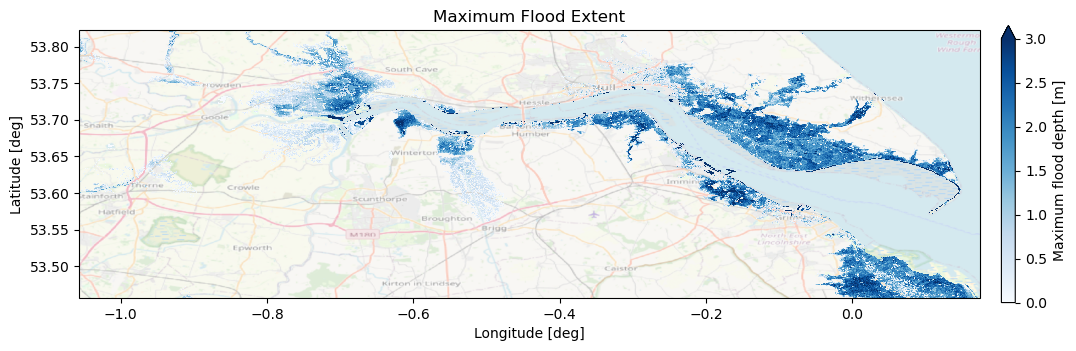

In [76]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(projection=proj)
hmax.plot(ax=ax, vmin=0, vmax=3, cmap="Blues",
          cbar_kwargs={
              'shrink': 0.3,
              "pad": 0.02,
          })
ax.set_xlim(region.total_bounds[[0,2]])
ax.set_ylim(region.total_bounds[[1,3]])
ax.add_image(cimgt.OSM(),10, interpolation='bilinear', alpha=0.5)
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel("Latitude [deg]")
ax.set_xlabel("Longitude [deg]")
# ax.set_title(f"Floodmap for event {scenario_name}")
ax.set_title("Maximum Flood Extent")

In [45]:
floodmap = xr.open_dataarray(floodmap_fn)
floodmap = floodmap.rio.reproject("EPSG:4326").squeeze()

In [69]:
gadm.unary_union.plot()

AttributeError: 'MultiPolygon' object has no attribute 'plot'

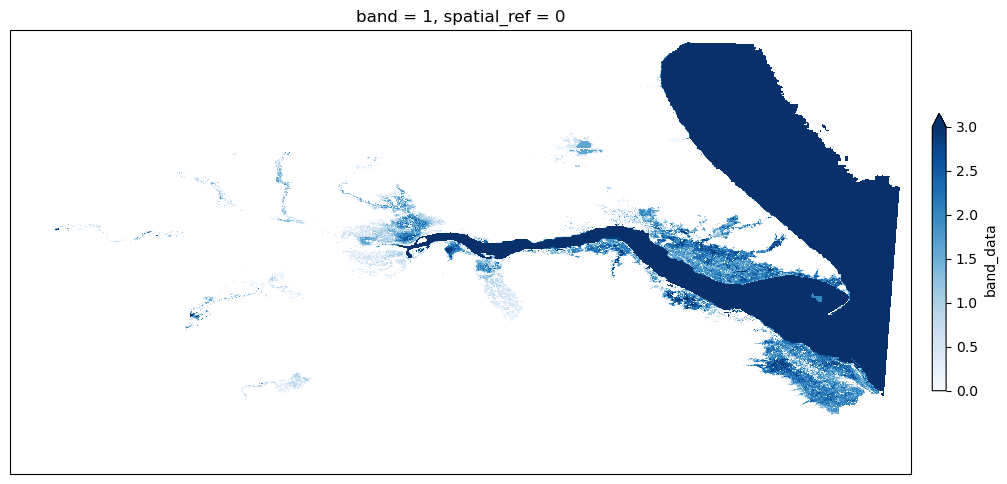

In [46]:
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(projection=proj)
floodmap.plot(ax=ax,
              vmin=0, vmax=3,
              cmap="Blues",
              cbar_kwargs={
                  'shrink': 0.3,
                  "pad": 0.02
              })

In [ ]:
sf.forcing.keys()

In [ ]:
sf.forcing['wind_u']

In [ ]:
sf.forcing['press_2d'].isel(time=67).plot.contour()

In [ ]:
sf.forcing['press_2d'].min().values

In [ ]:
h_xr.isel(time=40).plot()

In [ ]:
h_xr.max().values

In [ ]:
h_xr.chunk(dict(time=-1)).quantile([0.,0.98]).compute()

In [ ]:
from matplotlib import animation

# da = sf.forcing['press_2d']
da = h_xr

step = 12

# vmin, vmax = da.quantile([0., 0.98]).compute()
vmin=0
vmax=3
c_dem = plt.cm.viridis(np.linspace(0.25, 1, 512))
cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap_kwargs = dict(cmap=cmap, norm=norm) 

# def update_plot(i, da_h, cax_h):
#     da_hi = da_h.isel(time=i)
#     t = da_hi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
#     ax.set_title(f"Pressure Forcing {t}, max values: {da_hi.max().values}")
#     cax_h.set_array(da_hi.values.ravel())
#     cax_h.set_clim(vmin=da_hi.min().values, vmax=da_hi.max().values)

def update_plot(i, da_h):
    global cax_h, cl
    da_hi = da_h.isel(time=i)
    # for c in cax_h.collections:
    #     c.remove()
    # for l in cl:
    #     l.remove()
    cax_h = da_hi.plot(
        x='x', y='y', ax=ax,
        vmin=vmin, vmax=vmax, levels=100
    )
    # cax_h.set_clim(vmin=da_h.min().values, vmax=da_h.max().values)
    # cl = ax.clabel(cax_h)
    return cax_h

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection=proj)
ax.add_image(cimgt.OSM(),10, interpolation='bilinear')

# cax_h = da.isel(time=0).plot.contour(
#     x='x', y='y',
#     ax=ax,
#     vimn=vmin, vmax=vmax, levels=100,
#     # vmin=da.min().values, vmax=da.max().values, levels=100,
#     # add_colorbar=True,
#     # cbar_kwargs=cbar_kwargs
# )
# cbar = fig.colorbar(cax_h)

# for c in cax_h.collections:
#     c.remove()

cax_h = da.isel(time=0).plot(
    x='x', y='y',
    ax=ax,
    vmin=vmin, vmax=vmax, levels=100,
    # vmin=da.min().values, vmax=da.max().values, levels=100,
    # add_colorbar=True,
    # cbar_kwargs=cbar_kwargs
)
# cl = ax.clabel(cax_h)


ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0,da.time.size,step),
    interval=250,
    fargs=[da]
)

plt.close()

# ani.save('test_forcing_animation.gif', fps=4, dpi=200)

#show in notebook
from IPython.display import HTML

HTML(ani.to_jshtml())

In [ ]:
c_dem.shape

## FIAT output

In [ ]:
plot_fiat_model(fiat)

In [ ]:
fiat_output_path = fiat_path/"output"/"spatial.gpkg"

In [ ]:
fiat_output = gpd.read_file(fiat_output_path).to_crs("EPSG:4326")
fiat_output["Total Damage Normalized"] = fiat_output['Total Damage']/gdf_fiat["Max Potential Damage: Total"]

In [ ]:
fiat_output["Inundation Depth"].dropna().plot()

In [ ]:
fiat_output.plot(column="Total Damage Normalized", cmap='plasma')

In [ ]:
interval = np.linspace(0.25,1)
clrs = plt.cm.YlOrRd(interval)
cmap = colors.LinearSegmentedColormap.from_list('name', clrs)

In [ ]:
cmap

In [ ]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(projection=proj)
ax.add_image(cimgt.OSM(),10, interpolation='bilinear', alpha=0.3)
fiat_output.plot(ax=ax, column="Total Damage Normalized", legend=True, cmap=cmap,
    legend_kwds={'label': "Normalized Damages", "shrink": 0.4, "pad": 0.02})

ax.set_title("Building Damages, Normalized")
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel("Latitude [deg]")
ax.set_xlabel("Longitude [deg]")